In [1]:
from estival.model import BayesianCompartmentalModel
from estival import targets as est

import tbh.runner_tools as rt
from tbh.model import get_tb_model
from tbh.plotting import visualise_mle_params, plot_single_fit

In [2]:
params, priors, tv_params = rt.get_parameters_and_priors()
model = get_tb_model(rt.DEFAULT_MODEL_CONFIG, tv_params)
bcm = BayesianCompartmentalModel(model, params, priors, rt.targets)

In [3]:
import nevergrad as ng
from estival.wrappers.nevergrad import optimize_model

In [4]:
opt_class = ng.optimizers.NGOpt
orunner = optimize_model(bcm, opt_class=opt_class)
rec = orunner.minimize(2000)

In [5]:
mle_params = rec.value[1]
mle_params
res = bcm.run(mle_params)

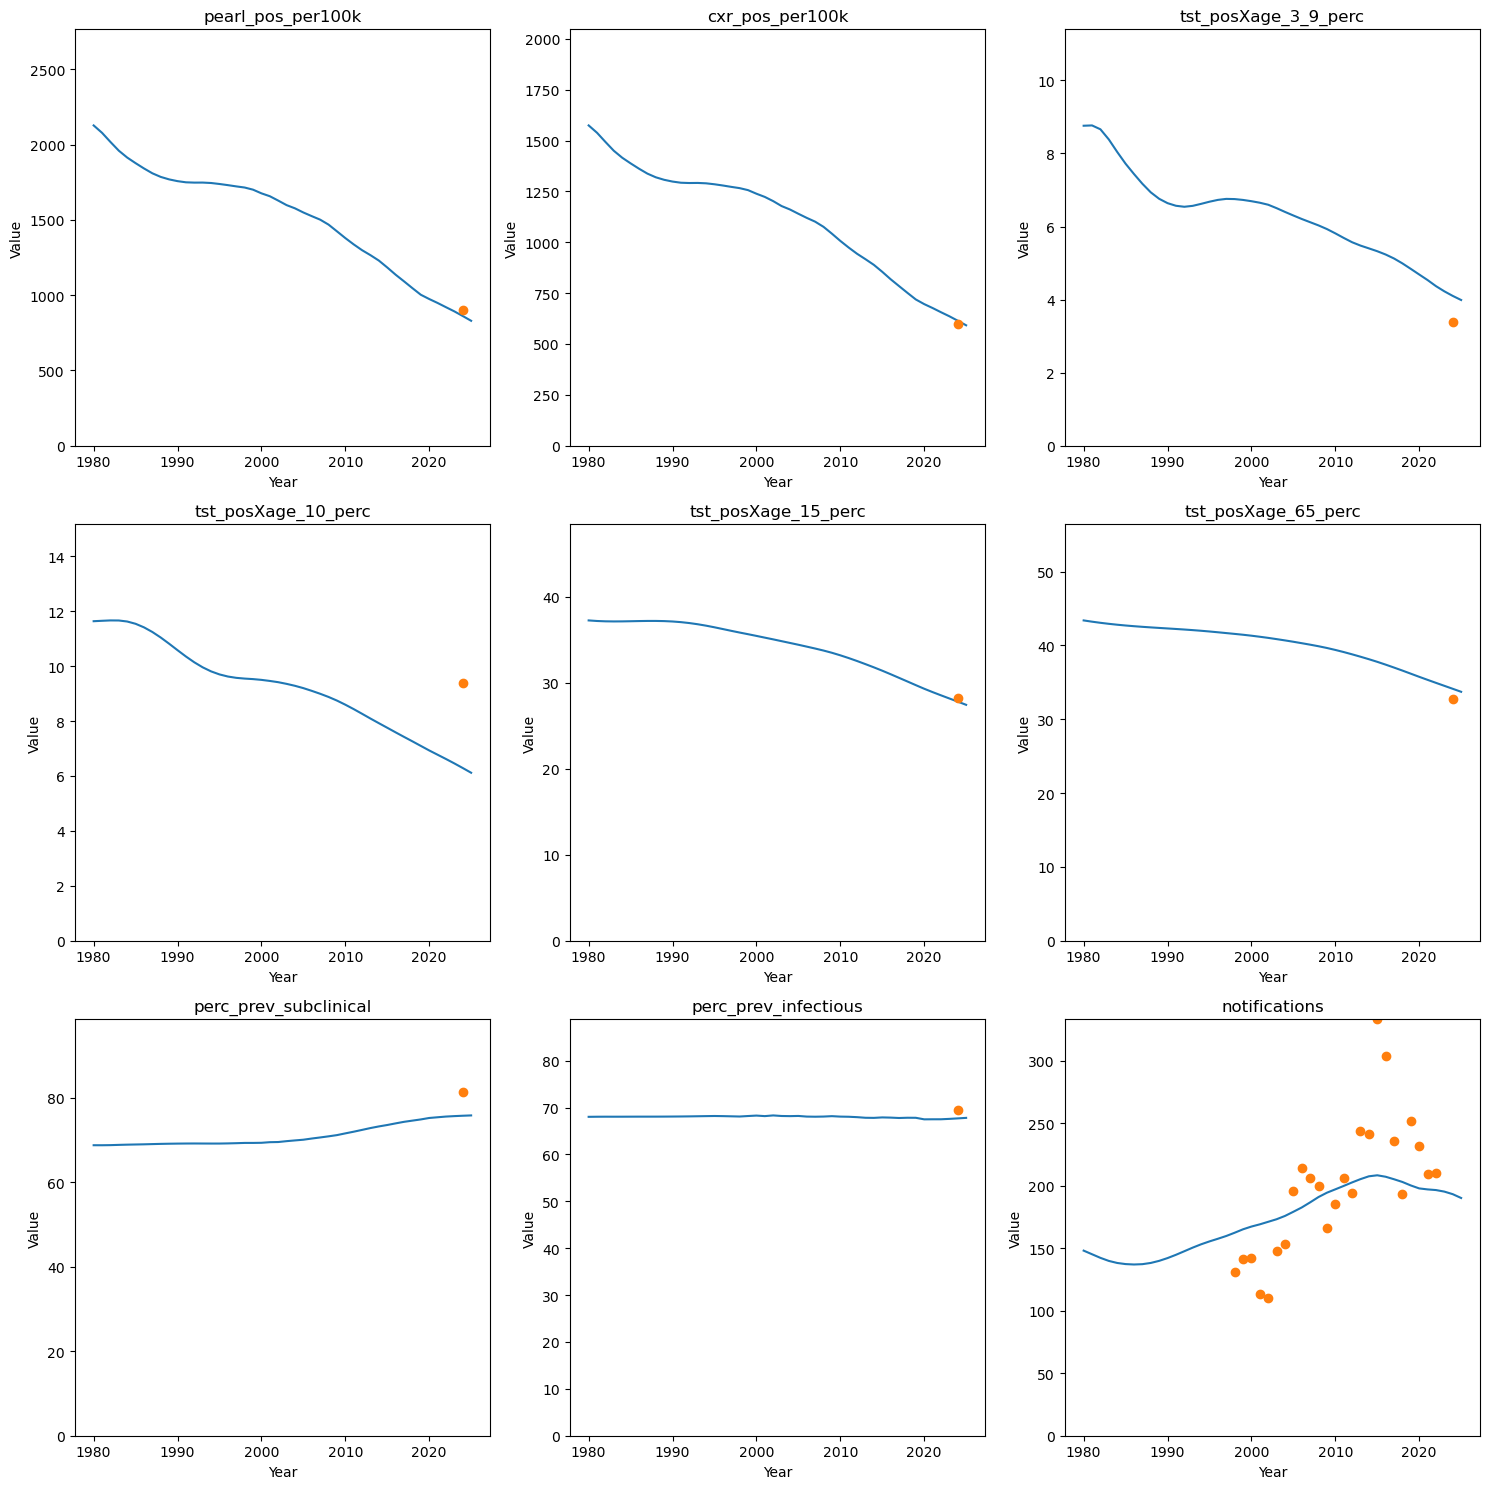

In [6]:
plot_single_fit(bcm, mle_params)

<Axes: >

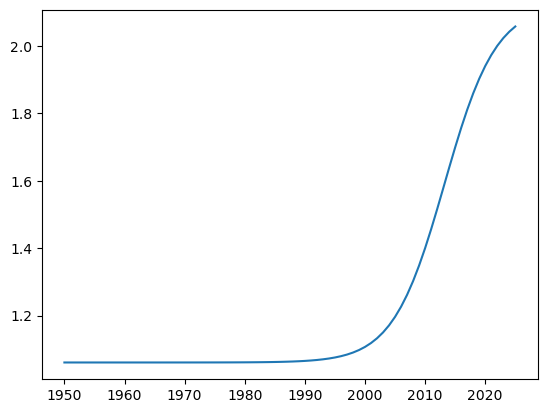

In [7]:
res.derived_outputs['passive_detection_rate_clin'].loc[1950:2025].plot()

In [8]:
year = 2025
deno = res.derived_outputs['tb_prevalence'].loc[year]
for state in ["subclin_lowinf", "clin_lowinf", "subclin_inf", "clin_inf"]:
    prev = res.derived_outputs[f"prev_{state}"].loc[year]
    print(f"% {state}: {round(100 * prev / deno)}")

KeyError: 'prev_subclin_lowinf'

In [ ]:
year = 2025
deno = res.derived_outputs['tbi_prevalence'].loc[year]
for state in ["incipient", "contained", "cleared"]:
    prev = res.derived_outputs[f"prev_{state}"].loc[year]
    print(f"% {state}: {round(100 * prev / deno)}")

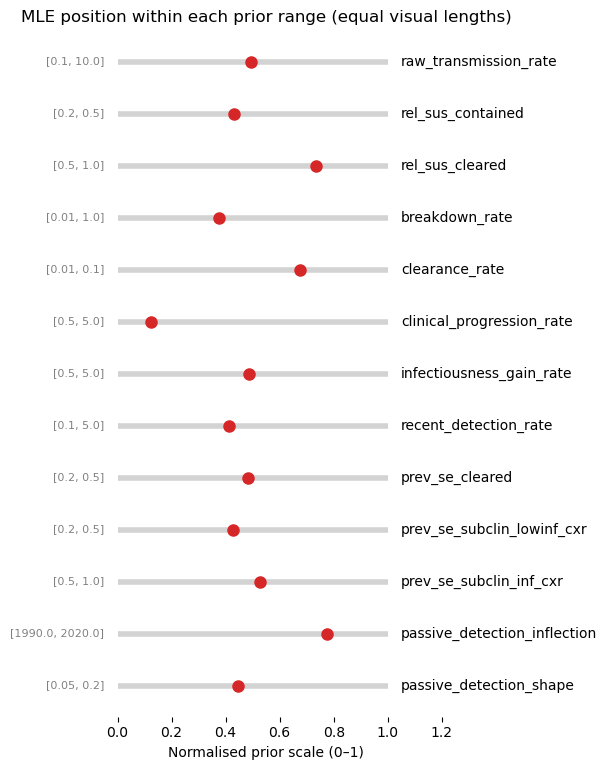

In [9]:
visualise_mle_params(bcm.priors, mle_params)